Compare coordinate descent to LARS-lasso using simulated data to study the
effects of correlation and increasing dimension p. Do the results between the methods change
as these parameters are altered?

      p  rho      method  test_mse        f1    time_s     alpha
0    50  0.0    CD-Lasso  4.459391  0.565796  0.027393  0.114089
1    50  0.0  LARS-Lasso  4.451050  0.565796  0.009623  0.112575
2    50  0.3    CD-Lasso  3.707555  0.527987  0.025205  0.097783
3    50  0.3  LARS-Lasso  3.701437  0.523244  0.009388  0.100620
4    50  0.6    CD-Lasso  3.228998  0.589027  0.031669  0.079652
5    50  0.6  LARS-Lasso  3.213331  0.575916  0.010623  0.080282
6    50  0.9    CD-Lasso  4.133229  0.524820  0.026482  0.055604
7    50  0.9  LARS-Lasso  4.135485  0.516890  0.011191  0.054417
8   200  0.0    CD-Lasso  4.178037  0.399373  0.061552  0.181271
9   200  0.0  LARS-Lasso  4.194131  0.400156  0.077849  0.184430
10  200  0.3    CD-Lasso  4.443562  0.368934  0.060683  0.154121
11  200  0.3  LARS-Lasso  4.454873  0.369292  0.084413  0.152256
12  200  0.6    CD-Lasso  3.641606  0.416062  0.087917  0.164550
13  200  0.6  LARS-Lasso  3.640720  0.417605  0.090110  0.165640
14  200  0.9    CD-Lasso 

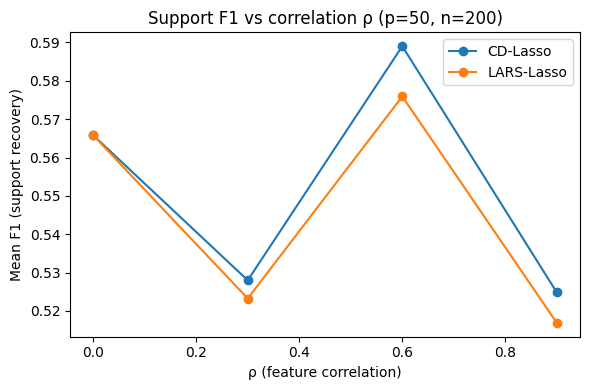

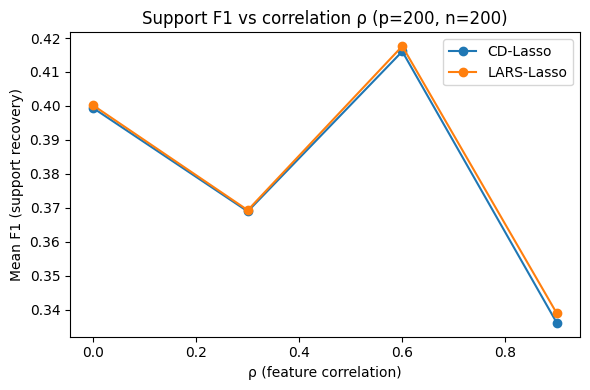

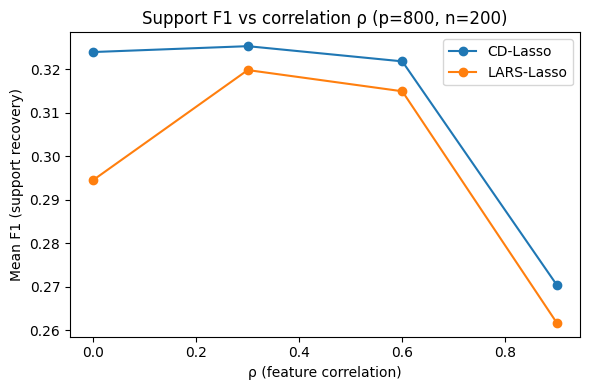

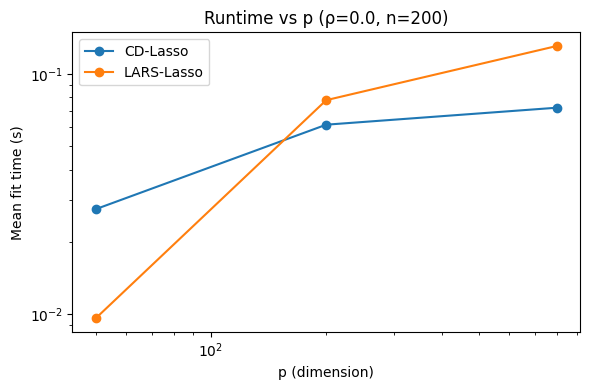

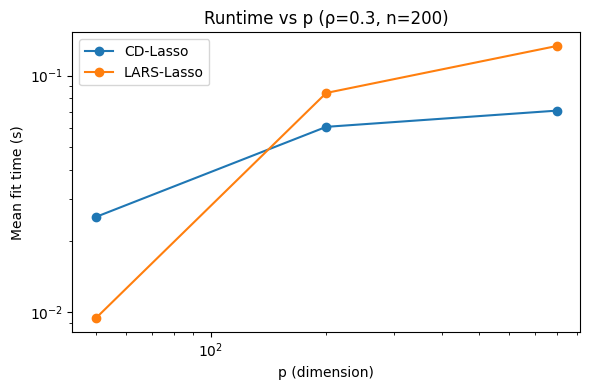

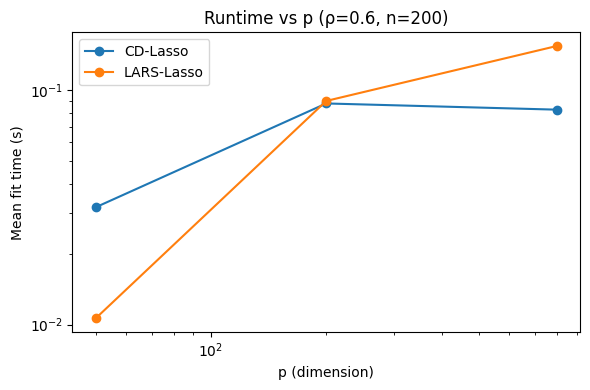

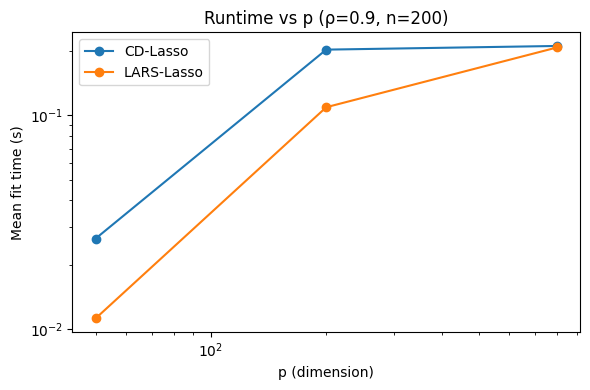

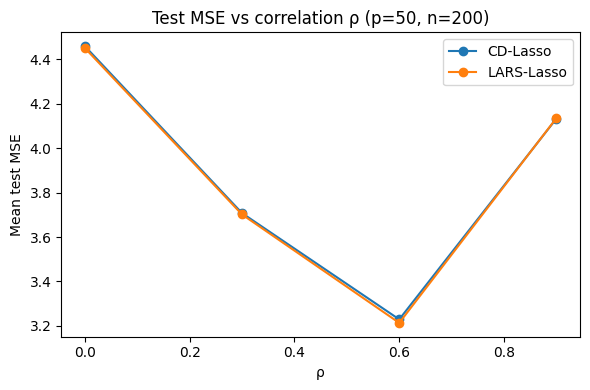

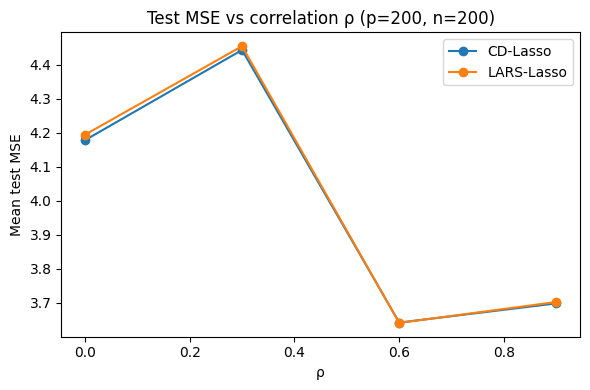

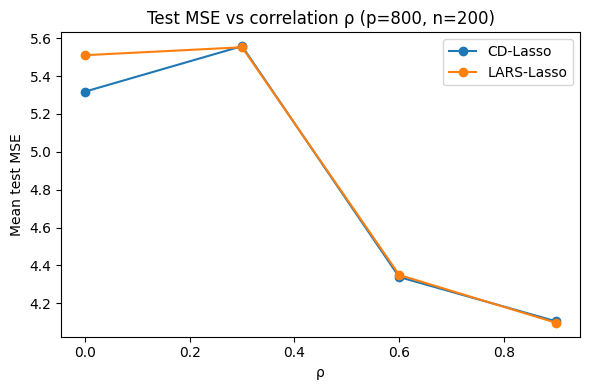

In [2]:
import numpy as np, time, warnings
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning)
rng = np.random.default_rng(7)


# Utilities

def toeplitz_cov(p, rho):
    # Sigma_ij = rho^{|i-j|}
    idx = np.arange(p)
    return rho ** np.abs(idx[:, None] - idx[None, :])

def simulate(n=200, p=200, rho=0.6, s=10, snr=5.0, seed=None):
    """Simulate y = X beta + eps with Toeplitz covariance and sparse beta.
       Returns standardized (X, y) and ground-truth support set.
    """
    rg = np.random.default_rng(seed)
    Sigma = toeplitz_cov(p, rho)
    X = rg.multivariate_normal(np.zeros(p), Sigma, size=n)

    # sparse beta: nonzeros at random positions with random signs
    supp = rg.choice(p, size=s, replace=False)
    beta = np.zeros(p)
    beta[supp] = rg.choice([-1, 1], size=s) * rg.uniform(0.5, 2.0, size=s)

    # set noise to achieve target SNR = Var(Xb) / Var(eps)
    Xb = X @ beta
    var_signal = np.var(Xb)
    var_noise = max(var_signal / snr, 1e-12)
    y = Xb + rg.normal(0, np.sqrt(var_noise), size=n)

    # standardize X and y (center & scale) so penalties are comparable
    X = (X - X.mean(0)) / (X.std(0, ddof=0) + 1e-12)
    y = y - y.mean()
    return X, y, beta, set(supp)

def support_f1(beta_hat, supp_true, tol=1e-8):
    supp_hat = set(np.flatnonzero(np.abs(beta_hat) > tol))
    tp = len(supp_hat & supp_true)
    fp = len(supp_hat - supp_true)
    fn = len(supp_true - supp_hat)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    f1   = 2*prec*rec / (prec + rec) if (prec + rec) else 0.0
    return prec, rec, f1, supp_hat

# Experiment grid

n = 200
p_list  = [50, 200, 800]
rho_list = [0.0, 0.3, 0.6, 0.9]
s = 10
snr = 5.0
replicates = 5

records = []

for p in p_list:
    for rho in rho_list:
        for rep in range(replicates):
            X, y, beta_true, supp_true = simulate(n=n, p=p, rho=rho, s=s, snr=snr,
                                                  seed=1000 + 17*p + rep)
            X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3,
                                                       random_state=42, stratify=None)

            # Coordinate-Descent Lasso with CV
            t0 = time.time()
            cd = LassoCV(cv=5, fit_intercept=False, max_iter=50000, n_jobs=-1)
            cd.fit(X_tr, y_tr)
            t_cd = time.time() - t0
            yhat_cd = cd.predict(X_te)
            mse_cd = mean_squared_error(y_te, yhat_cd)
            _, _, f1_cd, _ = support_f1(cd.coef_, supp_true)

            # LARS-Lasso with CV (exact path)
            t0 = time.time()
            lars = LassoLarsCV(cv=5, fit_intercept=False)
            # NOTE: we standardized X, so set normalize=False
            lars.fit(X_tr, y_tr)
            t_lars = time.time() - t0
            yhat_lars = lars.predict(X_te)
            mse_lars = mean_squared_error(y_te, yhat_lars)
            _, _, f1_lars, _ = support_f1(lars.coef_, supp_true)

            records.append({
                "p": p, "rho": rho,
                "method": "CD-Lasso",   "test_mse": mse_cd,   "f1": f1_cd,   "time_s": t_cd,
                "alpha": cd.alpha_
            })
            records.append({
                "p": p, "rho": rho,
                "method": "LARS-Lasso", "test_mse": mse_lars, "f1": f1_lars, "time_s": t_lars,
                "alpha": lars.alpha_
            })

# results table
df = pd.DataFrame(records)
# Aggregate by (p, rho, method)
summary = df.groupby(["p", "rho", "method"]).agg(
    test_mse=("test_mse", "mean"),
    f1=("f1", "mean"),
    time_s=("time_s", "mean"),
    alpha=("alpha", "median")
).reset_index()
print(summary)


# Plots (optional)

# 1) F1 vs rho for each p
for p in p_list:
    sub = summary[summary.p == p]
    plt.figure(figsize=(6,4))
    for m in ["CD-Lasso", "LARS-Lasso"]:
        ss = sub[sub.method == m]
        plt.plot(ss["rho"], ss["f1"], marker="o", label=m)
    plt.title(f"Support F1 vs correlation ρ (p={p}, n={n})")
    plt.xlabel("ρ (feature correlation)")
    plt.ylabel("Mean F1 (support recovery)")
    plt.legend(); plt.tight_layout(); plt.show()

# 2) Runtime vs p (at each rho)
for rho in rho_list:
    sub = summary[summary.rho == rho]
    plt.figure(figsize=(6,4))
    for m in ["CD-Lasso", "LARS-Lasso"]:
        ss = sub[sub.method == m].sort_values("p")
        plt.plot(ss["p"], ss["time_s"], marker="o", label=m)
    plt.title(f"Runtime vs p (ρ={rho}, n={n})")
    plt.xlabel("p (dimension)"); plt.ylabel("Mean fit time (s)")
    plt.xscale("log"); plt.yscale("log")
    plt.legend(); plt.tight_layout(); plt.show()

# 3) Test MSE vs rho (each p)
for p in p_list:
    sub = summary[summary.p == p]
    plt.figure(figsize=(6,4))
    for m in ["CD-Lasso", "LARS-Lasso"]:
        ss = sub[sub.method == m]
        plt.plot(ss["rho"], ss["test_mse"], marker="o", label=m)
    plt.title(f"Test MSE vs correlation ρ (p={p}, n={n})")
    plt.xlabel("ρ"); plt.ylabel("Mean test MSE")
    plt.legend(); plt.tight_layout(); plt.show()

Observation
1. As ρ increases (stronger collinearity):
	•   F1 falls for both (harder to identify the exact causal variable in a correlated block).
2.  LARS-Lasso shows larger variance and picking up one variable from a group aggressively whereas CD-Lasso tends to be a bit more stable.
3.  Runtimes: LARS gets slower because each step solves on a growing active set whereas CD remains steady.
4.  As p increases with n fixed (p>>n):    
•   Runtimes: CD scales better (near linear in p) LARS can degrade toward O(p^2) behavior due to linear algebra on the active set.  
•   Accuracy: Both see higher test MSE and lower F1 (statistical difficulty) whereas CD usually matches or slightly beats LARS in both metrics for large p.
